# LaserTag

This python notebook generates stats for the game of LaserTag we played on the 25th of May 2025. The raw timeseries data has already been processed using data.py

In [593]:
# importing the .csv file

import pandas as pd
import matplotlib.dates as mdates

timeseries = pd.read_csv("processed_timeseries.csv", index_col=None, header=0)
player_names = list(set(list(timeseries['tagger'])))

timeseries.head()

,timestamp,tagger,tagged
0,12:49:45,nikki,loki
1,12:49:49,marudhu,nikki
2,12:49:51,loki,shru
3,12:49:53,nitin,loki
4,12:49:55,nitin,marudhu


The final play stats for a typical game of Valorant can be found in valorant.txt, I am simply reproducing those statistics one by one in this notebook.

In [594]:
num_kills = [timeseries[timeseries['tagger'] == player].shape[0] for player in player_names]
num_deaths = [timeseries[timeseries['tagged'] == player].shape[0] for player in player_names]
KD_ratio = [num_kills[i]/num_deaths[i] for i in range(len(player_names))]

kills_and_deaths = pd.DataFrame([num_kills, num_deaths, KD_ratio], 
                                index=['Total Kills', 'Total Deaths', 'K/D Ratio'], 
                                columns=player_names)

print("Information about each player's total kills, total deaths, and their Kill-to-Death ratio:")
kills_and_deaths

Information about each player's total kills, total deaths, and their Kill-to-Death ratio:


,loki,nikki,shru,nitin,marudhu
Total Kills,109.000000,202.000000,81.000000,141.000000,124.000000
Total Deaths,157.000000,118.000000,166.000000,117.000000,99.000000
K/D Ratio,0.694268,1.711864,0.487952,1.205128,1.252525


In [595]:
# players with the most kills and most deaths
min_kills = max(num_kills)
min_kills_index = num_kills.index(min_kills)
player_with_min_kills = player_names[min_kills_index]

max_deaths = max(num_deaths)
max_deaths_index = num_deaths.index(max_deaths)
player_with_min_deaths = player_names[max_deaths_index]

print("Played with the most kills: ", player_with_min_kills)
print("Played with the most deaths: ", player_with_min_deaths)

Played with the most kills:  nikki
Played with the most deaths:  shru


In [596]:
# players with the least kills and least deaths
min_kills = min(num_kills)
min_kills_index = num_kills.index(min_kills)
player_with_min_kills = player_names[min_kills_index]

max_deaths = min(num_deaths)
max_deaths_index = num_deaths.index(max_deaths)
player_with_min_deaths = player_names[max_deaths_index]

print("Played with the least kills: ", player_with_min_kills)
print("Played with the least deaths: ", player_with_min_deaths)

Played with the least kills:  shru
Played with the least deaths:  marudhu


In [597]:
# Extracting each player's individual time series

all_players_timeseries = {player: 
                     timeseries[(timeseries['tagger'] == player) | (timeseries['tagged'] == player)] 
                     for player in player_names}

In [598]:
# Longest Kill Streak – Longest sequence of kills without dying.

for player in player_names:
    player_timeseries = all_players_timeseries[player]
    max_streak = 0
    current_streak = 0

    for _, row in player_timeseries.iterrows():
        if row['tagger'] == player:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        elif row['tagged'] == player:
            current_streak = 0

    print(f"{player}'s longest kill streak: {max_streak}")

print(f"\nThe player with the longest kill streak is nikki with 10 kills in a row. Not far behind is nitin with 9 kills.")

loki's longest kill streak: 5
nikki's longest kill streak: 14
shru's longest kill streak: 5
nitin's longest kill streak: 9
marudhu's longest kill streak: 5

The player with the longest kill streak is nikki with 10 kills in a row. Not far behind is nitin with 9 kills.


In [599]:
# Longest Time Alive – Longest time span without getting tagged.

for player in player_names:
    player_timeseries = all_players_timeseries[player].sort_values('timestamp')
    # Get all indices where player was tagged (killed)
    death_indices = player_timeseries.index[player_timeseries['tagged'] == player].tolist()
    timestamps = player_timeseries['timestamp']

    # Add start and end for edge cases
    all_indices = [player_timeseries.index[0] - 1] + death_indices + [player_timeseries.index[-1]]
    max_span = pd.Timedelta(0)
    max_start = None
    max_end = None

    for i in range(len(all_indices) - 1):
        start_idx = all_indices[i] + 1
        end_idx = all_indices[i + 1]
        if start_idx > end_idx or start_idx not in player_timeseries.index or end_idx not in player_timeseries.index:
            continue
        start_time = pd.to_datetime(player_timeseries.loc[start_idx, 'timestamp'])
        end_time = pd.to_datetime(player_timeseries.loc[end_idx, 'timestamp'])
        span = end_time - start_time
        if span > max_span:
            max_span = span
            max_start = start_time
            max_end = end_time
            
    # Format span as HH:MM:SS
    span_str = str(max_span).split()[-1] if "day" in str(max_span) else str(max_span)
    print(f"{player}'s longest time alive: {span_str} (from {max_start.time() if max_start is not None else '-'} to {max_end.time() if max_end is not None else '-'})")

print(f"\nThe player with the longest time span alive is nitin at 1 minute and 26 seconds (surprise surprise!?)")

loki's longest time alive: 00:00:20 (from 12:50:34 to 12:50:54)
nikki's longest time alive: 00:00:45 (from 13:16:57 to 13:17:42)
shru's longest time alive: 00:00:32 (from 13:15:46 to 13:16:18)
nitin's longest time alive: 00:01:31 (from 13:14:25 to 13:15:56)
marudhu's longest time alive: 00:00:30 (from 12:56:15 to 12:56:45)

The player with the longest time span alive is nitin at 1 minute and 26 seconds (surprise surprise!?)


In [600]:
# Fastest Kill After Spawn – Shortest time between getting tagged and tagging someone back.

for player in player_names:
    player_timeseries = all_players_timeseries[player].sort_values('timestamp')
    player_timeseries = player_timeseries.reset_index(drop=True)
    min_respawn_time = None
    min_respawn_start = None
    min_respawn_end = None

    # Find all indices where player was tagged (died)
    for i in range(len(player_timeseries) - 1):
        if player_timeseries.loc[i, 'tagged'] == player:
            # Look for the next event where player is the tagger (gets a kill)
            for j in range(i + 1, len(player_timeseries)):
                if player_timeseries.loc[j, 'tagger'] == player:
                    t1 = pd.to_datetime(player_timeseries.loc[i, 'timestamp'])
                    t2 = pd.to_datetime(player_timeseries.loc[j, 'timestamp'])
                    respawn_time = t2 - t1
                    # Only consider respawn times greater than or equal to 1 second
                    if respawn_time.total_seconds() >= 1:
                        if (min_respawn_time is None) or (respawn_time < min_respawn_time):
                            min_respawn_time = respawn_time
                            min_respawn_start = t1
                            min_respawn_end = t2
                        break  # Only consider the first kill after death
    if min_respawn_time is not None:
        span_str = str(min_respawn_time).split()[-1] if "day" in str(min_respawn_time) else str(min_respawn_time)
        print(f"{player}'s fastest kill after spawn (>=1s): {span_str} (from {min_respawn_start.time()} to {min_respawn_end.time()})")
    else:
        print(f"{player} never killed anyone after getting tagged with at least 1 second delay.")

print("\nIgnoring the errors in the data where two people killed each other the same instant, loki, nikki and shru are tied for fastest kill post-respawn")

loki's fastest kill after spawn (>=1s): 00:00:01 (from 13:16:43 to 13:16:44)
nikki's fastest kill after spawn (>=1s): 00:00:05 (from 12:50:20 to 12:50:25)
shru's fastest kill after spawn (>=1s): 00:00:05 (from 12:50:10 to 12:50:15)
nitin's fastest kill after spawn (>=1s): 00:00:02 (from 13:05:11 to 13:05:13)
marudhu's fastest kill after spawn (>=1s): 00:00:03 (from 12:59:06 to 12:59:09)

Ignoring the errors in the data where two people killed each other the same instant, loki, nikki and shru are tied for fastest kill post-respawn


In [601]:
# Most Consecutive Hits on Same Player – Who bullied whom the most in a row.

max_consecutive_hits = {}
for tagger in player_names:
    player_ts = all_players_timeseries[tagger].sort_values('timestamp')
    prev_tagged = None
    streak = 0
    max_streak = 0
    bully_victim = None

    for _, row in player_ts.iterrows():
        if row['tagger'] == tagger:
            if row['tagged'] == prev_tagged:
                streak += 1
            else:
                streak = 1
                prev_tagged = row['tagged']
            if streak > max_streak:
                max_streak = streak
                bully_victim = prev_tagged
        else:
            streak = 0
            prev_tagged = None

    max_consecutive_hits[tagger] = (bully_victim, max_streak)

print("The following are the pair-wise bullying stats:\n")
for tagger, (victim, streak) in max_consecutive_hits.items():
    print(f"{tagger} hit {victim} {streak} times in a row.")

The following are the pair-wise bullying stats:

loki hit nitin 3 times in a row.
nikki hit shru 3 times in a row.
shru hit loki 2 times in a row.
nitin hit marudhu 4 times in a row.
marudhu hit shru 3 times in a row.


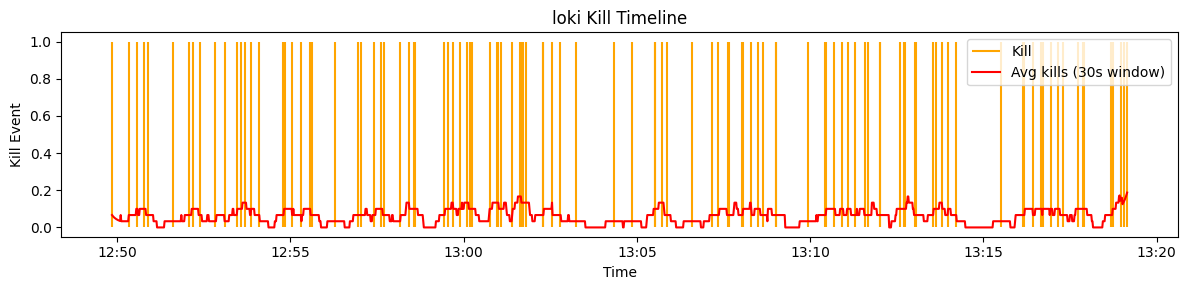

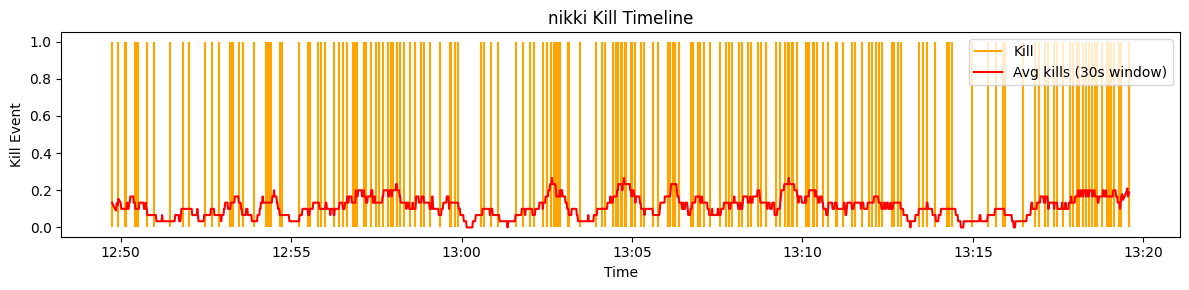

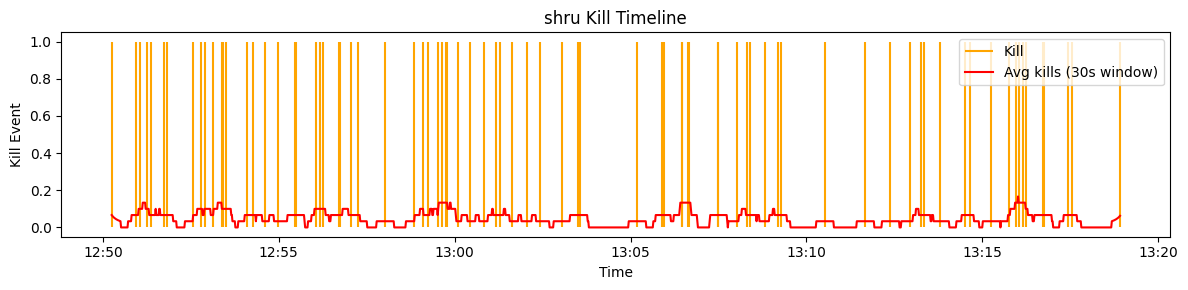

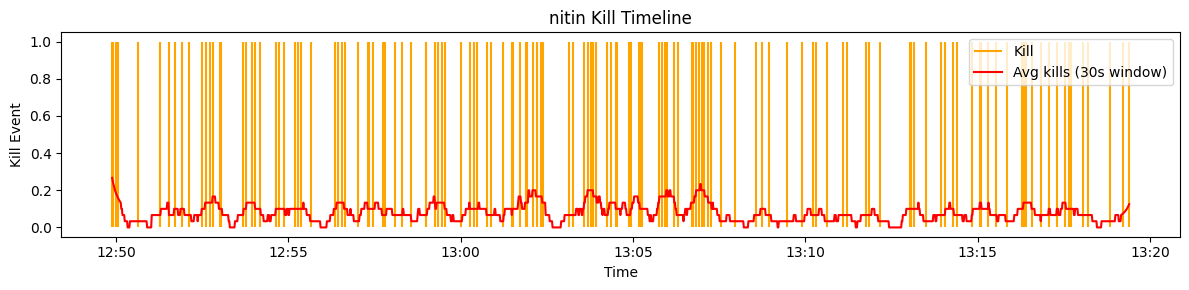

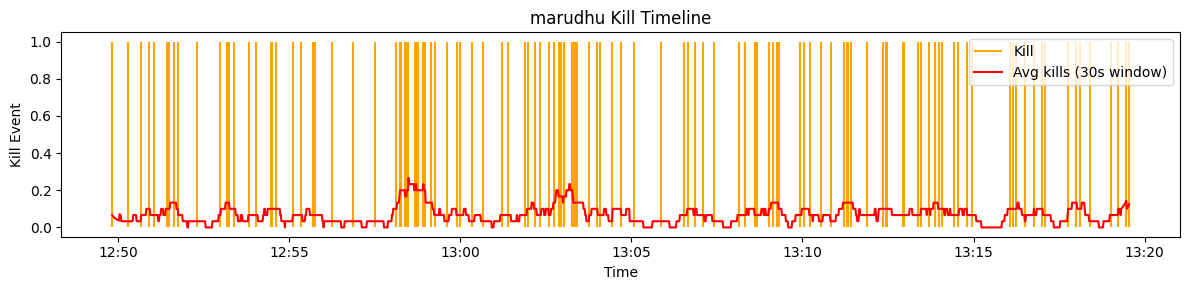

In [602]:
# Kill Timeline Graph – Time series showing each player’s kills over time.

import matplotlib.pyplot as plt
import os
%matplotlib inline

os.makedirs("timeseries_plots", exist_ok=True)

for player in player_names:
    player_timeseries = all_players_timeseries[player]
    # Only consider rows where player is the tagger (i.e., kills)
    kills = player_timeseries[player_timeseries['tagger'] == player].copy()
    kills['timestamp'] = pd.to_datetime(kills['timestamp'], format='%H:%M:%S')
    kills = kills.sort_values('timestamp')

    plt.figure(figsize=(12, 3))
    plt.title(f"{player} Kill Timeline")
    plt.xlabel("Time")
    plt.ylabel("Kill Event")

    # Plot kill spikes
    plt.vlines(kills['timestamp'], ymin=0, ymax=1, color='orange', label='Kill')

    # Convolution: moving average of kills per 30 seconds window
    kill_series = pd.Series(1, index=kills['timestamp'])
    kill_series = kill_series.resample('1s').sum().fillna(0)
    avg_kills = kill_series.rolling(window=30, min_periods=1, center=True).mean()
    plt.plot(avg_kills.index, avg_kills.values, color='red', label='Avg kills (30s window)')
    # Format x-axis to show only HH:MM
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


    plt.legend()
    plt.tight_layout()
    plt.savefig(f"timeseries_plots/{player}_kill_timeline", dpi=300)
    plt.show()


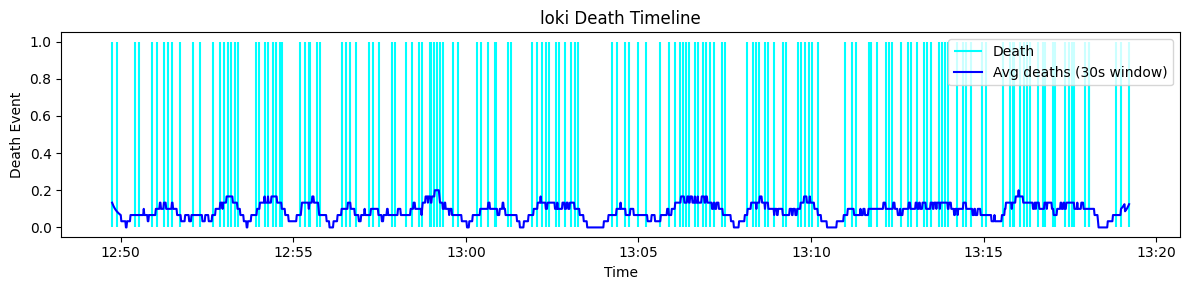

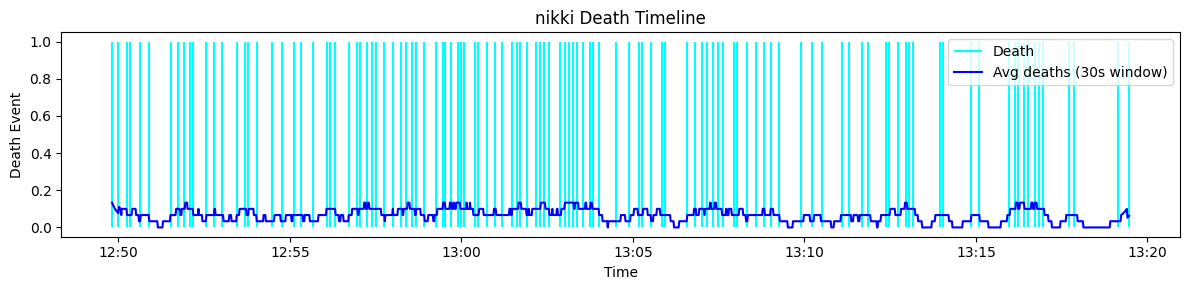

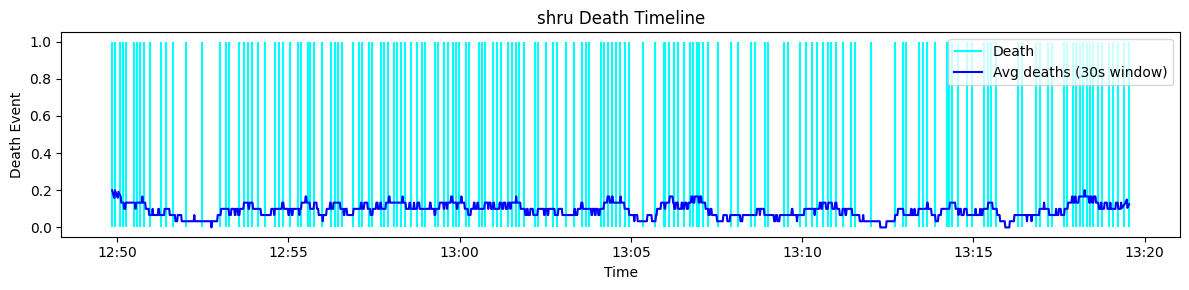

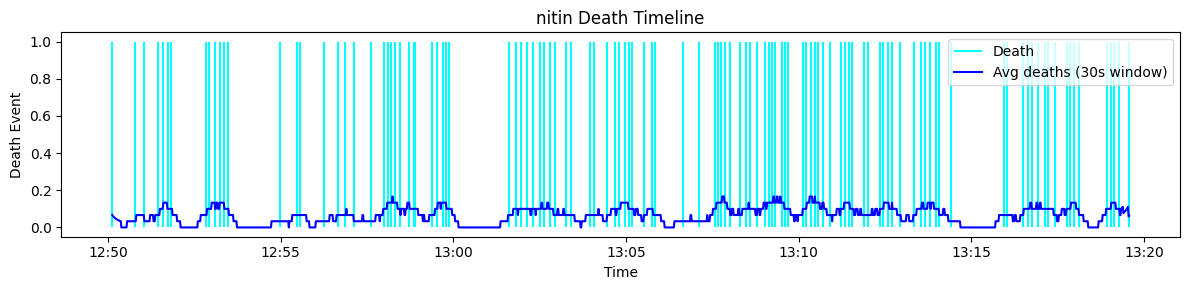

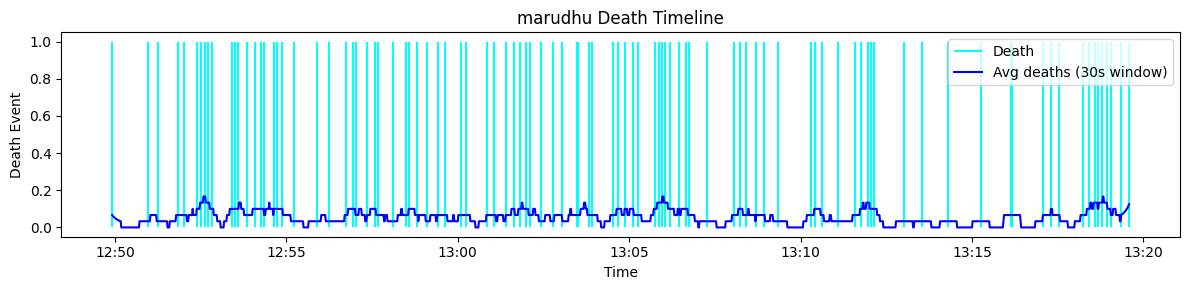

In [603]:
# Death Timeline Graph – Same, but for getting tagged.
import matplotlib.pyplot as plt
%matplotlib inline

for player in player_names:
    player_timeseries = all_players_timeseries[player]
    # Only consider rows where player is the tagged (i.e., deaths)
    deaths = player_timeseries[player_timeseries['tagged'] == player].copy()
    deaths['timestamp'] = pd.to_datetime(deaths['timestamp'], format='%H:%M:%S')
    deaths = deaths.sort_values('timestamp')

    plt.figure(figsize=(12, 3))
    plt.title(f"{player} Death Timeline")
    plt.xlabel("Time")
    plt.ylabel("Death Event")

    # Plot death spikes
    plt.vlines(deaths['timestamp'], ymin=0, ymax=1, color='cyan', label='Death')

    # Convolution: moving average of deaths per 30 seconds window
    death_series = pd.Series(1, index=deaths['timestamp'])
    death_series = death_series.resample('1s').sum().fillna(0)
    avg_deaths = death_series.rolling(window=30, min_periods=1, center=True).mean()
    plt.plot(avg_deaths.index, avg_deaths.values, color='blue', label='Avg deaths (30s window)')
    # Format x-axis to show only HH:MM
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


    plt.legend()
    plt.tight_layout()
    plt.savefig(f"timeseries_plots/{player}_death_timeline", dpi=300)
    plt.show()

Below is a symmetric matrix of pairwise tagger-tagged combinations:



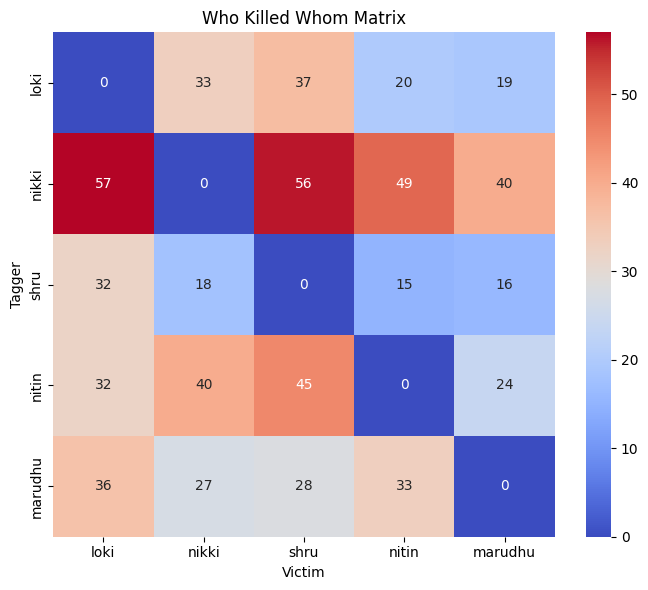

In [604]:
import seaborn as sns
import numpy as np

# Who Killed Whom – A matrix or list showing all kill interactions.

cross_kill_matrix = []

for player1 in player_names:
    for player2 in player_names:
        N_kills = timeseries[(timeseries['tagger'] == player1) & (timeseries['tagged'] == player2)].shape[0]
        cross_kill_matrix.append((player1, player2, N_kills))

import matplotlib.pyplot as plt

# Convert cross_kill_matrix to a DataFrame for heatmap plotting
matrix = np.zeros((len(player_names), len(player_names)), dtype=int)
for i, player1 in enumerate(player_names):
    for j, player2 in enumerate(player_names):
        matrix[i, j] = next(x[2] for x in cross_kill_matrix if x[0] == player1 and x[1] == player2)

who_killed_whom_df = pd.DataFrame(matrix, index=player_names, columns=player_names)

plt.figure(figsize=(7, 6))
sns.heatmap(who_killed_whom_df, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Who Killed Whom Matrix")
plt.xlabel("Victim")
plt.ylabel("Tagger")
plt.tight_layout()
print("Below is a symmetric matrix of pairwise tagger-tagged combinations:\n")
plt.savefig("who_killed_whom.png", dpi=300)
plt.show()

In [605]:
# Rivalries – Pairs that exchanged the most tags between them.
rivalries = []
max_exchanged = 0

for i, player1 in enumerate(who_killed_whom_df.index):
    for j, player2 in enumerate(who_killed_whom_df.columns):
        if i < j:  # avoid duplicates and self-pairs
            exchanged = who_killed_whom_df.loc[player1, player2] + who_killed_whom_df.loc[player2, player1]
            if exchanged > max_exchanged:
                max_exchanged = exchanged
                rivalries = [(player1, player2, exchanged)]
            elif exchanged == max_exchanged:
                rivalries.append((player1, player2, exchanged))

print("Rivalries (most exchanged tags):\n")
for p1, p2, count in rivalries:
    print(f"{p1} & {p2}: {count} tags exchanged")
    print("(Oh lawd)")

Rivalries (most exchanged tags):

loki & nikki: 90 tags exchanged
(Oh lawd)


In [606]:
# One-Sided Duels – Pairs where one player dominated (lead by >20 kills)
one_sided_duels = []
threshold = 10
for i, player1 in enumerate(who_killed_whom_df.index):
    for j, player2 in enumerate(who_killed_whom_df.columns):
        if player1 != player2:
            diff = who_killed_whom_df.loc[player1, player2] - who_killed_whom_df.loc[player2, player1]
            if diff > threshold:
                one_sided_duels.append((player1, player2, diff))

print(f"One-Sided Duels (lead > {threshold} kills):\n")
for p1, p2, diff in one_sided_duels:
    print(f"{p1} dominated {p2} by {diff} kills")

One-Sided Duels (lead > 10 kills):

nikki dominated loki by 24 kills
nikki dominated shru by 38 kills
nikki dominated marudhu by 13 kills
nitin dominated loki by 12 kills
nitin dominated shru by 30 kills
marudhu dominated loki by 17 kills
marudhu dominated shru by 12 kills


In [607]:
# Most Kills on One Player – Who targeted one person the most.

max_kills_on_one = None
max_kills_count = 0
for tagger in player_names:
    for victim in player_names:
        if tagger != victim:
            kills = who_killed_whom_df.loc[tagger, victim]
            if kills > max_kills_count:
                max_kills_count = kills
                max_kills_on_one = (tagger, victim, kills)
print(f"Most kills on one player: {max_kills_on_one[0]} killed {max_kills_on_one[1]} {max_kills_on_one[2]} times.")

Most kills on one player: nikki killed loki 57 times.


In [608]:
# "Sharpshooter" – Best K/D ratio.

best_kd = max(KD_ratio)
best_kd_index = KD_ratio.index(best_kd)
print(f'Sharpshooter (Best K/D): {player_names[best_kd_index]} with K/D ratio {best_kd:.2f}')

Sharpshooter (Best K/D): nikki with K/D ratio 1.71


In [609]:
# "Ghost" – Least deaths.

least_deaths = min(num_deaths)
least_deaths_index = num_deaths.index(least_deaths)
print(f'Ghost (Least deaths): {player_names[least_deaths_index]} with {least_deaths} deaths')

Ghost (Least deaths): marudhu with 99 deaths


In [610]:
# "Tank" - Most deaths but still had kills.

most_deaths = max(num_deaths)
most_deaths_index = num_deaths.index(most_deaths)
if num_kills[most_deaths_index] > 0:
    print(f'Tank (Most deaths but still had kills): {player_names[most_deaths_index]} with {most_deaths} deaths and {num_kills[most_deaths_index]} kills')
else:
    print('No player with deaths and kills found.')


Tank (Most deaths but still had kills): shru with 166 deaths and 81 kills


In [611]:
# "Revenge Master" – Most revenge kills (killed someone who just killed them).

revenge_counts = {player: 0 for player in player_names}
for player in player_names:
    ts = all_players_timeseries[player].sort_values('timestamp').reset_index(drop=True)
    for i in range(1, len(ts)):
        if ts.loc[i-1, 'tagged'] == player and ts.loc[i, 'tagger'] == player:
            if ts.loc[i-1, 'tagger'] == ts.loc[i, 'tagged']:
                revenge_counts[player] += 1
revenge_master = max(revenge_counts, key=revenge_counts.get)
print(f'Revenge Mistress: {revenge_master} with {revenge_counts[revenge_master]} revenge kills')


Revenge Mistress: nikki with 31 revenge kills


In [612]:
# "Comeback King" – Longest kill streak after a death streak.

comeback_streaks = {}
for player in player_names:
    ts = all_players_timeseries[player].sort_values('timestamp')
    streak = 0
    max_streak = 0
    after_death = False
    for _, row in ts.iterrows():
        if row['tagged'] == player:
            streak = 0
            after_death = True
        elif row['tagger'] == player and after_death:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            after_death = False
    comeback_streaks[player] = max_streak
comeback_king = max(comeback_streaks, key=comeback_streaks.get)
print(f'Comeback Queen: {comeback_king} with a streak of {comeback_streaks[comeback_king]} kills after a death')

Comeback Queen: nikki with a streak of 14 kills after a death


In [613]:
# "Aggressor" – Highest kill rate per minute.

kill_rates = []
for player in player_names:
    kills = all_players_timeseries[player][all_players_timeseries[player]['tagger'] == player].copy()
    if not kills.empty:
        kills['timestamp'] = pd.to_datetime(kills['timestamp'], format='%H:%M:%S')
        duration = (kills['timestamp'].max() - kills['timestamp'].min()).total_seconds() / 60
        rate = kills.shape[0] / duration if duration > 0 else 0
    else:
        rate = 0
    kill_rates.append(rate)
aggressor_index = kill_rates.index(max(kill_rates))
print(f'Aggressor (Highest kill rate): {player_names[aggressor_index]} with {kill_rates[aggressor_index]:.2f} kills/min')

Aggressor (Highest kill rate): nikki with 6.77 kills/min


In [614]:
# "Survivor" – Longest average time between deaths.

avg_time_between_deaths = {}
for player in player_names:
    ts = all_players_timeseries[player].sort_values('timestamp')
    death_times = pd.to_datetime(ts[ts['tagged'] == player]['timestamp'], format='%H:%M:%S')
    if len(death_times) > 1:
        avg_span = (death_times.diff().dropna().mean())
    else:
        avg_span = pd.Timedelta(0)
    avg_time_between_deaths[player] = avg_span
survivor = max(avg_time_between_deaths, key=avg_time_between_deaths.get)

hhmmss = str(avg_time_between_deaths[survivor]).split()[-1].split('.')[0]
print(f'Survivor (Longest avg time between deaths): {survivor} with {hhmmss}')

Survivor (Longest avg time between deaths): marudhu with 00:00:18


In [615]:
# "Focused Fury" – Most kills on the same player in a row.

focused_fury = None
max_streak = 0
for tagger in player_names:
    player_ts = all_players_timeseries[tagger].sort_values('timestamp')
    prev_tagged = None
    streak = 0
    for _, row in player_ts.iterrows():
        if row['tagger'] == tagger:
            if row['tagged'] == prev_tagged:
                streak += 1
            else:
                streak = 1
                prev_tagged = row['tagged']
            if streak > max_streak:
                max_streak = streak
                focused_fury = (tagger, prev_tagged, streak)
        else:
            streak = 0
            prev_tagged = None
print(f'Focused Fury: {focused_fury[0]} killed {focused_fury[1]} {focused_fury[2]} times in a row')

Focused Fury: nitin killed marudhu 4 times in a row


---

This is just some more additional stuff :3

This is a plot of every kill event over the entire game: 



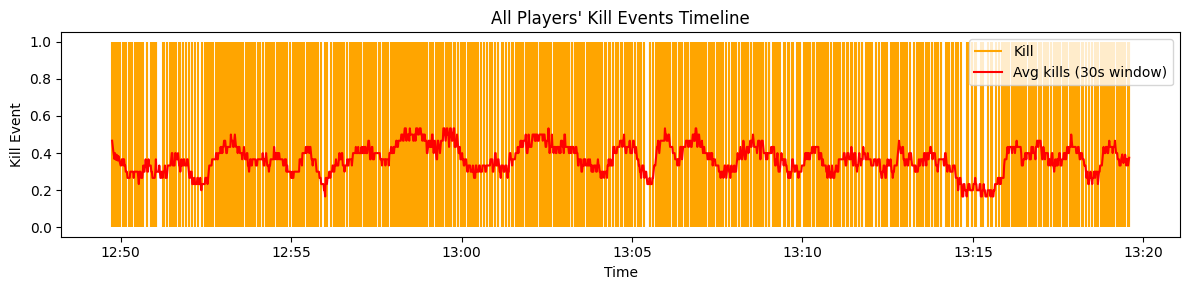

In [622]:
# just plotting all players' kills and deaths as a function of time to see if there are any trends :) 
# for example with the switching off of the lights


# Only consider rows where player is the tagger (i.e., kills)
kills = pd.concat([all_players_timeseries[player][all_players_timeseries[player]['tagger'] == player] for player in player_names])
kills['timestamp'] = pd.to_datetime(kills['timestamp'], format='%H:%M:%S')
kills = kills.sort_values('timestamp')

plt.figure(figsize=(12, 3))
plt.title(f"All Players' Kill Events Timeline")
plt.xlabel("Time")
plt.ylabel("Kill Event")

# Plot kill spikes
plt.vlines(kills['timestamp'], ymin=0, ymax=1, color='orange', label='Kill')

# Convolution: moving average of kills per 30 seconds window
kill_series = pd.Series(1, index=kills['timestamp'])
kill_series = kill_series.resample('1s').sum().fillna(0)
avg_kills = kill_series.rolling(window=30, min_periods=1, center=True).mean()
plt.plot(avg_kills.index, avg_kills.values, color='red', label='Avg kills (30s window)')
# Format x-axis to show only HH:MM
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


plt.legend()
plt.tight_layout()
print("This is a plot of every kill event over the entire game: \n")
plt.savefig(f"timeseries_plots/all_kill_events_timeline", dpi=300)
plt.show()


This is a plot of every kill event over the entire game: 



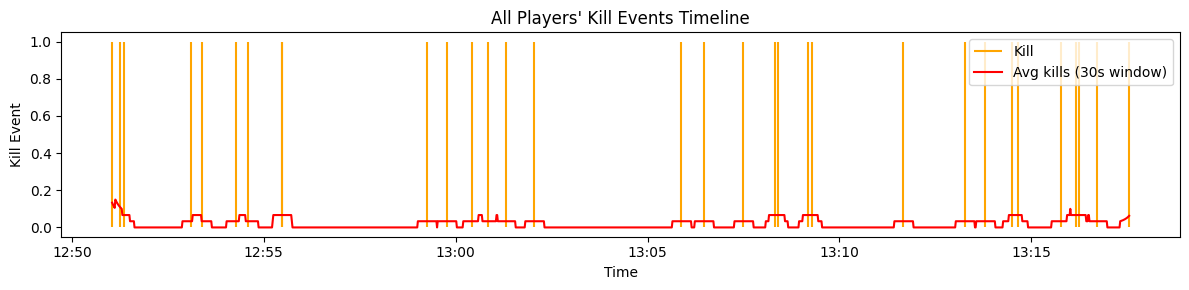

In [632]:
# checking whether shru took advantage of loki making videos in the middle of the game

# Only consider rows where player is the tagger (i.e., kills)
tagger_s = 'shru'
tagged_s = 'loki'
kills = all_players_timeseries[tagger_s][all_players_timeseries[tagger_s]['tagger'] == tagger_s]
kills = kills[kills['tagged'] == tagged_s]
kills['timestamp'] = pd.to_datetime(kills['timestamp'], format='%H:%M:%S')
kills = kills.sort_values('timestamp')

plt.figure(figsize=(12, 3))
plt.title(f"All Players' Kill Events Timeline")
plt.xlabel("Time")
plt.ylabel("Kill Event")

# Plot kill spikes
plt.vlines(kills['timestamp'], ymin=0, ymax=1, color='orange', label='Kill')

# Convolution: moving average of kills per 30 seconds window
kill_series = pd.Series(1, index=kills['timestamp'])
kill_series = kill_series.resample('1s').sum().fillna(0)
avg_kills = kill_series.rolling(window=30, min_periods=1, center=True).mean()
plt.plot(avg_kills.index, avg_kills.values, color='red', label='Avg kills (30s window)')
# Format x-axis to show only HH:MM
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


plt.legend()
plt.tight_layout()
print("This is a plot of every kill event over the entire game: \n")
plt.savefig(f"timeseries_plots/all_kill_events_timeline", dpi=300)
plt.show()
